In [22]:
name1 = "Daniela Gonzalez Favero" 
name2 = "Miguel Pereira Ostrowski"

honorPledge = "I affirm that I have not given or received any unauthorized " \
              "help on this assignment, and that this work is my own.\n"


print("\nName: ", name1)
print("\nHonor pledge: ", honorPledge)

print("\nName: ", name2)
print("\nHonor pledge: ", honorPledge)


Name:  Daniela Gonzalez Favero

Honor pledge:  I affirm that I have not given or received any unauthorized help on this assignment, and that this work is my own.


Name:  Miguel Pereira Ostrowski

Honor pledge:  I affirm that I have not given or received any unauthorized help on this assignment, and that this work is my own.



# MAC0460 / MAC5832 (2021)
---

## EP4

### Objectives:
The aim of this EP is to
- Practice training of linear, neural networks, and SVMs classifiers using the scikit-learn library (https://scikit-learn.org/)
- Practice model evaluation, comparison and selection
- Produce a summary report on the performed experiments and main findings


In [23]:
# All imports

import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist

from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.neural_network import MLPClassifier

from sklearn.metrics import mean_squared_error, classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV

%matplotlib inline

# 1. Dataset preparation
## 1.1. Downloading data
Reading the MNIST dataset using the `tensorflow.keras` library:

In [24]:
(X_train_ori, y_train_ori), (X_test_ori, y_test_ori) = mnist.load_data()

print(X_train_ori.shape, y_train_ori.shape)
print(X_test_ori.shape, y_test_ori.shape)

(60000, 28, 28) (60000,)
(10000, 28, 28) (10000,)


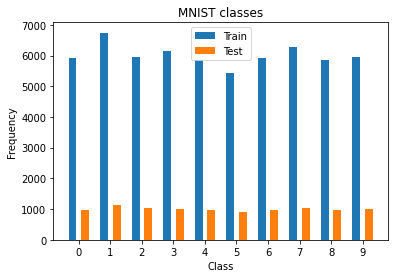

In [25]:
labels = ["%s"%i for i in range(10)]

unique, counts = np.unique(y_train_ori, return_counts=True)
uniquet, countst = np.unique(y_test_ori, return_counts=True)

fig, ax = plt.subplots()
rects1 = ax.bar(unique - 0.2, counts, 0.25, label='Train')
rects2 = ax.bar(unique + 0.2, countst, 0.25, label='Test')
ax.legend()
ax.set_xticks(unique)
ax.set_xticklabels(labels)

plt.title('MNIST classes')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.show()

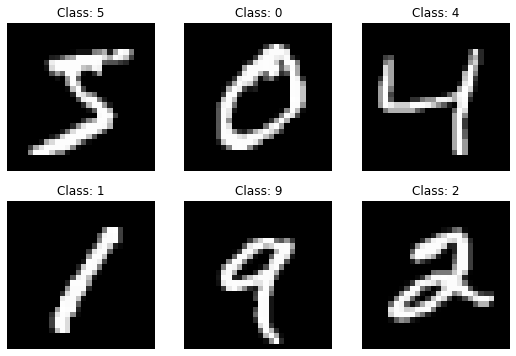

In [26]:
fig, ax = plt.subplots(2, 3, figsize = (9, 6))

for i in range(6):
    ax[i//3, i%3].imshow(X_train_ori[i], cmap='gray')
    ax[i//3, i%3].axis('off')
    ax[i//3, i%3].set_title("Class: %d"%y_train_ori[i])
    
plt.show()

## 1.2. Preprocessing
Reducing the image size:

In [27]:
# Reduce the image size to its half 
X_train = np.array([image[::2, 1::2] for image in X_train_ori])
X_test  = np.array([image[::2, 1::2] for image in X_test_ori])

y_train = y_train_ori
y_test = y_test_ori

y_train_padrao = y_train

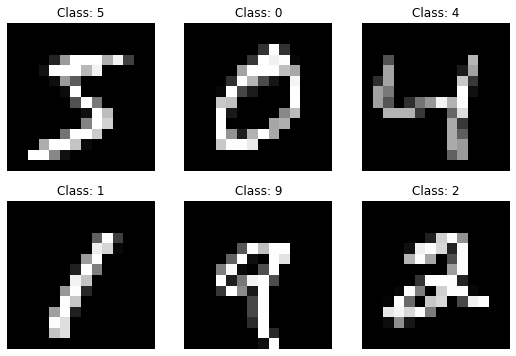

In [28]:
fig, ax = plt.subplots(2, 3, figsize = (9, 6))

for i in range(6):
    ax[i//3, i%3].imshow(X_train[i], cmap='gray')
    ax[i//3, i%3].axis('off')
    ax[i//3, i%3].set_title("Class: %d"%y_train_ori[i])
    
plt.show()

Normalizing the intensities to the interval $[0, 1]$:

In [29]:
X_train = (X_train/255.0).astype('float32').reshape((60000,14*14))
X_test = (X_test/255.0).astype('float32').reshape((10000,14*14))

print(X_train.dtype)
print(X_test.dtype)

print("\nShape of X_train: ", X_train.shape)
print("Shape of X_test: ", X_test.shape)

print("\nMinimum value in X_train:", np.amin(X_train))
print("Maximum value in X_train:", np.amax(X_train))

print("\nMinimum value in X_test:", np.amin(X_test))
print("Maximum value in X_test:", np.amax(X_test))


float32
float32

Shape of X_train:  (60000, 196)
Shape of X_test:  (10000, 196)

Minimum value in X_train: 0.0
Maximum value in X_train: 1.0

Minimum value in X_test: 0.0
Maximum value in X_test: 1.0


## 1.3. Partitioning dataset
Partitioning the original training set into 70% training ($D_{train}$) and 30% validation ($D_{val}$) sets, in a stratified way:


In [30]:
SEED = 512
FRACTION = 30/100
D_train, D_val, y_train, y_val = train_test_split(X_train, 
                                                  y_train, 
                                                  test_size=FRACTION, 
                                                  random_state=SEED
                                                 )

print(D_train.shape)
print(D_val.shape)
print(y_train.shape)
print(y_val.shape)

(42000, 196)
(18000, 196)
(42000,)
(18000,)


# 2. Training, evaluating and selecting models
Now, we will use $D_{train}$ to train and select three models: a logistic regression model, a neural network model, and a SVM model.


## 2.1. Model selection method


To test different values for hyperparameters and choose the most adequate model, we use the `scikit-learn` library's class `GridSearchCV`. Defining some candidates to hyperparameters, the class will print some metrics and show how we should select the models.

After that, we use some metrics implemented in `scikit-learn` library in the `model_selection_metrics()` function, to conclude the choices we made.

In [31]:
def model_selection_metrics(y, y_predict):
    """
    Computes three different metrics to evaluate model performance: 'Mean 
    squared error', 'Classification report' (several metrics, such as precision,
    recall, etc) and the 'Confusion matrix'
    :param y: class labels
    :type y: np.ndarray(shape=(N, ))
    :param y_predict: predicted class labels
    :type y_predict: np.ndarray(shape=(N, ))
    """  

    print()
    print("Mean squared error:\n", mean_squared_error(y, y_predict))

    print()
    print("Classification report:\n", classification_report(y, y_predict))

    print()
    print("Confusion matrix:\n", confusion_matrix(y, y_predict))

## 2.2. Logistic Regression
Firstly, we use the `GridSearchCV` to find the best cadidates to parameters of the Logistic Regression:

In [32]:
tuned_parameters = [{'C':            np.logspace(-3,3,7),
                     'penalty':      ['l2'],
                     'solver':       ['newton-cg', 'lbfgs', 'sag'],
                     'random_state': [SEED],
                     'max_iter':     [3000]},
                     {'C':           np.logspace(-3,3,7),
                     'penalty':      ['l1', 'l2'],
                     'solver':       ['liblinear'],
                     'random_state': [SEED],
                     'max_iter':     [3000]}
                     ]

scores = ['precision', 'recall']

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf = GridSearchCV(
        LogisticRegression(), tuned_parameters, scoring='%s_macro' % score, n_jobs=-1
    )
    clf.fit(D_train, y_train)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))

# Tuning hyper-parameters for precision

Best parameters set found on development set:

{'C': 10.0, 'max_iter': 3000, 'penalty': 'l2', 'random_state': 512, 'solver': 'lbfgs'}

Grid scores on development set:

0.848 (+/-0.007) for {'C': 0.001, 'max_iter': 3000, 'penalty': 'l2', 'random_state': 512, 'solver': 'newton-cg'}
0.848 (+/-0.007) for {'C': 0.001, 'max_iter': 3000, 'penalty': 'l2', 'random_state': 512, 'solver': 'lbfgs'}
0.848 (+/-0.007) for {'C': 0.001, 'max_iter': 3000, 'penalty': 'l2', 'random_state': 512, 'solver': 'sag'}
0.885 (+/-0.006) for {'C': 0.01, 'max_iter': 3000, 'penalty': 'l2', 'random_state': 512, 'solver': 'newton-cg'}
0.885 (+/-0.005) for {'C': 0.01, 'max_iter': 3000, 'penalty': 'l2', 'random_state': 512, 'solver': 'lbfgs'}
0.885 (+/-0.006) for {'C': 0.01, 'max_iter': 3000, 'penalty': 'l2', 'random_state': 512, 'solver': 'sag'}
0.903 (+/-0.008) for {'C': 0.1, 'max_iter': 3000, 'penalty': 'l2', 'random_state': 512, 'solver': 'newton-cg'}
0.903 (+/-0.008) for {'C'

Thus, we conclude that the best parameters in this model are:
```
C = 1e-3,
penalty = 'l2',
solver = 'lbfgs',
max_iter: 5000
```
(The selection of `max_iter` took into account how many iterations were necessary so that the model would converge, and it was adjusted manually)

Now, let's use the `scikit-learn` library implementation of Logistic Regression to train the dataset with the chosen parameters:

In [33]:
# training
clf = LogisticRegression(random_state=SEED, max_iter=2000).fit(D_train, y_train)

# predicting
y_predict = clf.predict(D_train)

Printing performance metrics such as the *classifier score* and the *model selection method* that we defined previously:

In [16]:
print()
print("Classifier score:\n" , clf.score(D_train, y_train))

print()
model_selection_metrics(y_train, y_predict)


Classifier score:
 0.916


Mean squared error:
 1.4490714285714286

Classification report:
               precision    recall  f1-score   support

           0       0.96      0.97      0.96      4142
           1       0.94      0.97      0.95      4685
           2       0.92      0.89      0.90      4141
           3       0.90      0.88      0.89      4325
           4       0.91      0.92      0.92      4087
           5       0.88      0.87      0.88      3848
           6       0.94      0.95      0.95      4194
           7       0.93      0.93      0.93      4398
           8       0.89      0.87      0.88      4076
           9       0.88      0.90      0.89      4104

    accuracy                           0.92     42000
   macro avg       0.92      0.91      0.91     42000
weighted avg       0.92      0.92      0.92     42000


Confusion matrix:
 [[4003    1   14    8    9   35   30   10   29    3]
 [   1 4543   24   14    4   19    2   15   55    8]
 [  21   50 3689   63 

## 2.3. Neural Network
Now, we use the `GridSearchCV` to find the best candidates to parameters of the Multi-layer Perceptron:

In [19]:
tuned_parameters = [{'hidden_layer_sizes': np.arange(10, 14),
                     'activation': ['identity', 'logistic', 'tanh', 'relu'],
                     'solver':     ['lbfgs', 'sgd', 'adam'],
                     'alpha':      np.logspace(-4, -3, 2),
                     'learning_rate_init': np.logspace(-3, -1, 3),
                     'random_state': [SEED],
                     'max_iter':     [500]}
                     ]

scores = ['precision', 'recall']

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf = GridSearchCV(
        MLPClassifier(), tuned_parameters, scoring='%s_macro' % score, n_jobs=-1
    )
    clf.fit(D_train, y_train)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))

# Tuning hyper-parameters for precision



C:\Users\Miguel\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Best parameters set found on development set:

{'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': 13, 'learning_rate_init': 0.01, 'max_iter': 500, 'random_state': 512, 'solver': 'sgd'}

Grid scores on development set:

0.908 (+/-0.009) for {'activation': 'identity', 'alpha': 0.0001, 'hidden_layer_sizes': 10, 'learning_rate_init': 0.001, 'max_iter': 500, 'random_state': 512, 'solver': 'lbfgs'}
0.905 (+/-0.009) for {'activation': 'identity', 'alpha': 0.0001, 'hidden_layer_sizes': 10, 'learning_rate_init': 0.001, 'max_iter': 500, 'random_state': 512, 'solver': 'sgd'}
0.908 (+/-0.008) for {'activation': 'identity', 'alpha': 0.0001, 'hidden_layer_sizes': 10, 'learning_rate_init': 0.001, 'max_iter': 500, 'random_state': 512, 'solver': 'adam'}
0.908 (+/-0.009) for {'activation': 'identity', 'alpha': 0.0001, 'hidden_layer_sizes': 10, 'learning_rate_init': 0.01, 'max_iter': 500, 'random_state': 512, 'solver': 'lbfgs'}
0.907 (+/-0.009) for {'activation': 'identity', 'alpha': 0.0001, '

C:\Users\Miguel\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Thus, we conclude that the best parameters in this model are:
```

max_iter: 500
```
(The selection of `max_iter` took into account how many iterations were necessary so that the model would converge, and it was adjusted manually. We also observed that too many iterations would lead the model to overfit: it'd have `score=1`)

Now, let's use the `scikit-learn` library implementation of the Multi-layer Perceptron to train the dataset with the chosen parameters:

In [20]:
# training
nn = MLPClassifier(random_state=SEED, max_iter=500, learning_rate_init=0.01, hidden_layer_sizes=(10, )).fit(D_train, y_train)

# predicting
y_predict_nn = nn.predict(D_train)

Printing performance metrics such as the *classifier score* and the *model selection method* that we defined previously:

In [34]:
print()
print("Classifier score:\n" , nn.score(D_train, y_train))

print()
model_selection_metrics(y_train, y_predict_nn)


Classifier score:
 0.9340238095238095


Mean squared error:
 1.1034761904761905

Classification report:
               precision    recall  f1-score   support

           0       0.97      0.97      0.97      4142
           1       0.96      0.97      0.97      4685
           2       0.93      0.95      0.94      4141
           3       0.96      0.86      0.91      4325
           4       0.91      0.93      0.92      4087
           5       0.91      0.92      0.91      3848
           6       0.96      0.96      0.96      4194
           7       0.94      0.94      0.94      4398
           8       0.94      0.90      0.92      4076
           9       0.86      0.94      0.90      4104

    accuracy                           0.93     42000
   macro avg       0.93      0.93      0.93     42000
weighted avg       0.94      0.93      0.93     42000


Confusion matrix:
 [[4023    1   16    2   14   15   32   14   14   11]
 [   1 4549   29   13    6   16    5   12   35   19]
 [  21   

## 2.4. SVM
Initially, we had to choose between the several SVM implementation in the library. We began with a *Radial Basis Function (RBF)* kernel (using the `sklearn.svm.SVC` class) and, although it classified very well, the program took too long to finish compared to the previous methods, and it didn't compensate.

Therefore, let's use the `GridSearchCV` to find the best candidates to parameters of a Linear Support Vector Machine:


In [35]:
tuned_parameters = [{'penalty':      ['l2'],
                     'dual':         [False],
                     'loss' :        ['hinge', 'squared_hinge'],
                     'C':            [1, 10, 100, 1000],
                     'tol':          [1e-3, 1e-4],
                     'random_state': [SEED],
                     'max_iter':     [5000]}]

scores = ['precision', 'recall']

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf = GridSearchCV(
        LinearSVC(), tuned_parameters, scoring='%s_macro' % score, n_jobs=-1
    )
    clf.fit(D_train, y_train)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))

# Tuning hyper-parameters for precision



C:\Users\Miguel\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Miguel\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Miguel\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\svm\_classes.py", line 234, in fit
    self.coef_, self.intercept_, self.n_iter_ = _fit_liblinear(
  File "C:\Users\Miguel\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\svm\_base.py", line 974, in _fit_liblinear
    solver_type = _get_liblinear_solver_type(multi_class, penalty, loss, dual)
  File "C:\Users\Miguel\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\svm\_base.py", line 830, in _g

KeyboardInterrupt: 

Thus, we conclude that the best parameters in this model are:
```
C = 10,
penalty = 'l2',
loss = 'squared_hinge',
dual = [False],
tol = 1e-3,
max_iter: 5000
```
(The selection of `max_iter` took into account how many iterations were necessary so that the model would converge, and it was adjusted manually)

Using the `scikit-learn` library implementation of a Linear Support Vector Machine to train the dataset with the chosen parameters:

In [ ]:
# training
svm_clf = LinearSVC(random_state=SEED, max_iter=5000).fit(D_train, y_train)

# predicting
y_predict_svm = svm_clf.predict(D_train)

Printing performance metrics such as the *classifier score* and the *model selection method* that we defined previously:

In [ ]:
print()
print("Classifier score:\n" , svm_clf.score(D_train, y_train))

print()
model_selection_metrics(y_train, y_predict_svm)

# 3. Choosing a final model
Now, evaluating – on the validation set ($D_{val}$) – the three models selected in the previous step.  
 Let's compare the performance computed with respect to ($D_{val}$) with the ones obtained in the previous step (in $D_{train}$):

## 3.1. Validating the logistic regression model

In [ ]:
# predicting
y_predict_val = clf.predict(D_val)

# estimating metrics
print()
print('Classifier score:\n', clf.score(D_val, y_val))

print()
model_selection_metrics(y_val, y_predict_val)

## 3.2. Validating the multi-layer perceptron model

In [ ]:
# predicting
y_predict_nn_val = nn.predict(D_val)

# estimating metrics
print()
print('Classifier score:\n', nn.score(D_val, y_val))

print()
model_selection_metrics(y_val, y_predict_nn_val)

## 3.3. Validating the linear SVM model

In [ ]:
# predicting
y_predict_svm_val = svm_clf.predict(D_val)

# estimating metrics
print()
print('Classifier score:\n', svm_clf.score(D_val, y_val))

print()
model_selection_metrics(y_val, y_predict_svm_val)

## 3.4. Comparing the three models
The computed metrics on the validation set can be more clearly compared through the table:

|                   | Score | MSE  | Accuracy |  
|:-----------------:|:-----:|:----:|:--------:|  
| Linear Regression | 0.91  | 1.56 | 0.91     |
| Neural Networks   | 0.92  | 1.35 | 0.92     |
| Linear SVM        | 0.90  | 1.74 | 0.90     |

Thus, we can conclude that the **Neural Networks** have the highest score and accuracy, and also the lowest error; so that's our final chosen model.




# 4. Error estimation
Computing an estimate of the final model expected performance ($E_{out}$ and other metrics/analysis).

## 4.1. Estimating metrics over $D_{test}$
Printing $E_{out}$ and other metrics/analysis, using neural networks:

In [ ]:
# predicting
y_predict_nn_test = nn.predict(X_test)

# estimating metrics
print()
print('Classifier score:\n', nn.score(X_test, y_test))

print()
model_selection_metrics(y_test, y_predict_nn_test)

Now, let's do a **Cross validation**, comparing the error outputs of training versus testing:

|            | MSE  |
|:----------:|:----:| 
| Training   | 1.20 | 
| Validating | 1.35 | 
| Testing    | 1.26 |

<!-- TODO: COMENTAR SOBRE A CROSS VALIDATION -->

## 4.2. Retraining the selected method on $D_{train} \cup D_{val}$
Now, let's retrain the neural network on $D_{train} \cup D_{val}$ and verify if there is any significant
difference:

In [ ]:
# training
nn2 = MLPClassifier(random_state=SEED, max_iter=500, learning_rate_init=0.01, hidden_layer_sizes=(10, )).fit(X_train, y_train_padrao)

# predicting
y_predict_nn2 = nn2.predict(X_train)

Printing performance metrics such as the *classifier score* and the *model selection method* that we defined previously:

In [ ]:
# estimating metrics
print()
print('Classifier score:\n', nn2.score(X_train, y_train_padrao))

print()
model_selection_metrics(y_train_padrao, y_predict_nn2)

Computing an estimate of the final model expected performance ($E_{out}$ and other metrics/analysis):

In [ ]:
y_predict_nn2_test = nn2.predict(X_test)
print('Classifier score:\n', nn2.score(X_test, y_test))

model_selection_metrics(y_test, y_predict_nn2_test)

The performance metrics computed on $D_{train} \cup D_{val}$ still hold the high score and accuracy, and also the low error. That means that the output error $E_{out}$ is low, and our choices of a model keep showing to be a precise fit for the dataset.